# **Cancel Culture - Classification Modeling Notebook**

---

**Post-Cleaning Modeling Notebook**

---

# -- > 🛑 **FIX**: Add cmts re: post-cleaning, modeling

---

>

---

# **Imports**

---

**The Basics**

>I will import the usual packages: Pandas, Numpy, Matplotlib, and Seaborn. Additionally, I have several personal functions that I use during the modeling process.

**More Models**

> When I begin the modeling process, I will import 

---

In [47]:
## Jupyter Notebook setting to reload functions when called
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Visualizing model results
import shap

## Personal functions
from bmc_functions import classification as clf

## SKLearn and Modeling Tools
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,\
                                    RepeatedStratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn import set_config

from imblearn.over_sampling import SMOTENC

In [49]:
## Settings
%matplotlib inline
sns.set_context("paper", font_scale=1.25)

pd.set_option('display.max_columns', 150)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 50)

set_config(display='diagram')

## *Speeding-Up Scikit-Learn*

---

Due to the size of my dataset, the modeling process took a fair amount of time, especially when testing different model types. To improve my models' runtime, I use a package called "**Intel(R) Extension for Scikit-learn*.**"

This package operates in the background to increase the computational efficiency of certain Scikit-Learn models, including Logistic Regression and Random Forest Classifier models. The package does not affect the model results, though.

This package requires the models to be imported after the package itself in order to perform the patching that results in better run-times.

---

In [50]:
## Speeding up SKLearn via Intel(R) Extension for Scikit-learn*
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [51]:
## Inmporting models post-sklearn-intelex
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# **Reading the DataFrames**

---

> In my prior EDA notebook, I reviewed, cleaned, and performed some pre-processing steps to prepare my data separately before modeling. I saved the data as a .pickle file to preserve the datatypes; now I will re-read the data for modeling purposes.

---

In [52]:
data = pd.read_pickle('./data/data_no_assigned.pickle',
                           compression = 'gzip')
data

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status_date,agent_group,arrival_date,arrival_day
0,Resort Hotel,0,342,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,0,0,0,C,3,No Deposit,0,Transient,0.00,0,0,2015-07-01,999,2015-07-01,Wednesday
1,Resort Hotel,0,737,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,0,0,0,C,4,No Deposit,0,Transient,0.00,0,0,2015-07-01,999,2015-07-01,Wednesday
2,Resort Hotel,0,7,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,0,0,0,A,0,No Deposit,0,Transient,75.00,0,0,2015-07-02,999,2015-07-01,Wednesday
3,Resort Hotel,0,13,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,0,0,0,A,0,No Deposit,0,Transient,75.00,0,0,2015-07-02,999,2015-07-01,Wednesday
4,Resort Hotel,0,14,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,0,0,0,A,0,No Deposit,0,Transient,98.00,0,1,2015-07-03,240,2015-07-01,Wednesday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119385,City Hotel,0,23,August,35,30,2,5,2,0.00,0,BB,BEL,Offline TA/TO,0,0,0,A,0,No Deposit,0,Transient,96.14,0,0,2017-09-06,999,2017-08-30,Wednesday
119386,City Hotel,0,102,August,35,31,2,5,3,0.00,0,BB,FRA,Online TA,0,0,0,E,0,No Deposit,0,Transient,225.43,0,2,2017-09-07,9,2017-08-31,Thursday
119387,City Hotel,0,34,August,35,31,2,5,2,0.00,0,BB,DEU,Online TA,0,0,0,D,0,No Deposit,0,Transient,157.71,0,4,2017-09-07,9,2017-08-31,Thursday
119388,City Hotel,0,109,August,35,31,2,5,2,0.00,0,BB,GBR,Online TA,0,0,0,A,0,No Deposit,0,Transient,104.40,0,0,2017-09-07,999,2017-08-31,Thursday


# **Train/Test Split**

In [53]:
## Splitting data into features and target variables.
target= 'is_canceled'

X = data.drop(columns = [target]).copy()
y = data[target].copy()

In [54]:
## Checking for missing values
print(f'Missing values for X:\n {X.isna().sum()[X.isna().sum() >0]}\n')
print(f'Missing values for y: {y.isna().sum()}')

Missing values for X:
 Series([], dtype: int64)

Missing values for y: 0


In [55]:
## Splitting - stratify to maintain class balance b/t X_train/_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state=42, 
                                                    stratify=y)

In [56]:
## Saving memory by deleting unused X, y
del X, y

In [57]:
## Specifying numeric columns for preprocessing
num_cols = X_train.select_dtypes('number').columns.to_list()
num_cols

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [58]:
## Specifying numeric columns for preprocessing
cat_cols = X_train.select_dtypes(include='object').columns.to_list()
cat_cols

['hotel',
 'arrival_date_month',
 'meal',
 'country',
 'market_segment',
 'reserved_room_type',
 'deposit_type',
 'customer_type',
 'agent_group',
 'arrival_day']

# **Prepping the Pipeline**

---

> Pipeline to streamline modeling steps:
* Preprocessing: OHE, scaling, outliers via ƒ-XF?
* Modeling: RFC, BRFC
* GSCV: include as part of pipeline
* Get results:
    * Feature importances - **SHAP**

---

In [59]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding

### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore',
                                                 sparse=False))])

num_pipe = Pipeline(steps=[('scaler', StandardScaler())])

### --- Instantiating the ColumnTransformer --- ###
preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['lead_time', 'arrival_date_week_number',
                                  'arrival_date_day_of_month',
                                  'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled',
                                  'booking_changes', 'days_in_waiting_list',
                                  'adr', 'required_car_parking_spaces',
                                  'total_of_special_requests']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['hotel', 'arrival_date_month', 'meal',
                                  'country', 'market_segment',
                                  'reserved_room_type', 'deposit_type',
                                  'customer_type', 'agent_group',
                                  'arrival_day'])])

In [60]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

## Getting feature names from OHE
ohe_cat_names = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_cols)

## Generating list for column index
final_cols = [*num_cols, *ohe_cat_names]

final_cols

['lead_time',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_City Hotel',
 'hotel_Resort Hotel',
 'arrival_date_month_April',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'meal_BB',
 'meal_FB',
 'meal_HB',
 'meal_SC',
 'meal_Undefined',
 'country_ABW',
 'country_AGO',
 'country_AIA',
 'country_ALB',
 'country_AND',
 'country_ARE',
 'country_ARG',
 'country_ARM',
 'country_ASM',
 'country_ATA',
 'count

In [61]:
## Transform via the ColumnTransformer preprocessor and create new dataframe

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                             columns=final_cols, index=X_train.index)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                            columns=final_cols, index=X_test.index)

display(X_train_df.head(5),X_test_df.head(5))

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,...,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VNM,country_ZAF,country_ZMB,country_ZWE,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,agent_group_1,agent_group_240,agent_group_9,agent_group_999,arrival_day_Friday,arrival_day_Monday,arrival_day_Saturday,arrival_day_Sunday,arrival_day_Thursday,arrival_day_Tuesday,arrival_day_Wednesday
67110,0.52,-0.75,1.39,0.07,-0.26,0.24,-0.26,-0.08,-0.18,-0.10,-0.09,-0.33,-0.13,0.56,-0.25,-0.72,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
95128,0.42,0.43,-0.43,0.07,-0.26,0.24,4.77,-0.08,-0.18,-0.10,-0.09,-0.33,-0.13,1.83,3.85,0.54,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
49525,0.21,-0.82,-0.21,-0.93,0.26,0

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,meal_BB,meal_FB,meal_HB,meal_SC,meal_Undefined,country_ABW,country_AGO,country_AIA,country_ALB,country_AND,country_ARE,country_ARG,country_ARM,country_ASM,country_ATA,country_ATF,country_AUS,country_AUT,country_AZE,country_BEL,country_BEN,country_BFA,country_BGD,country_BGR,country_BHR,country_BIH,country_BLR,country_BOL,country_BRA,country_BRB,country_CAF,country_CHE,country_CHL,country_CHN,country_CIV,country_CMR,country_CN,country_COL,country_COM,country_CPV,country_CRI,country_CUB,country_CYM,country_CYP,country_CZE,...,country_PRY,country_PYF,country_QAT,country_ROU,country_RUS,country_RWA,country_SAU,country_SDN,country_SEN,country_SGP,country_SLE,country_SLV,country_SMR,country_SRB,country_STP,country_SUR,country_SVK,country_SVN,country_SWE,country_SYC,country_SYR,country_TGO,country_THA,country_TJK,country_TMP,country_TUN,country_TUR,country_TWN,country_TZA,country_UGA,country_UKR,country_URY,country_USA,country_UZB,country_VEN,country_VNM,country_ZAF,country_ZMB,country_ZWE,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Direct,market_segment_Groups,market_segment_Offline TA/TO,market_segment_Online TA,market_segment_Undefined,reserved_room_type_A,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,reserved_room_type_H,reserved_room_type_L,reserved_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,agent_group_1,agent_group_240,agent_group_9,agent_group_999,arrival_day_Friday,arrival_day_Monday,arrival_day_Saturday,arrival_day_Sunday,arrival_day_Thursday,arrival_day_Tuesday,arrival_day_Wednesday
34262,-0.50,-1.19,-0.32,0.07,0.79,0.24,-0.26,-0.08,-0.18,-0.10,-0.09,1.18,-0.13,-0.62,-0.25,0.54,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
78954,-0.94,-1.70,0.70,-0.93,-0.78,-1.45,-0.26,-0.08,5.55,-0.10,4.57,-0.33,-0.13,-0.70,-0.25,-0.72,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
13185,-0.71,0.28,-1.34,-0.93,-

# **Setting Cross-Validator**

---

> To confirm my models' performance, I will use the `RepeatedStratifiedKFold` cross-validation technique with Scikit-Learn's  `cross_val_score()` function to validate each fitted model's performance.
>
> I set the `cv` variable prior to modeling for the convenience during repeated cross-validations.

---

In [62]:
cv = RepeatedStratifiedKFold(n_splits = 3, n_repeats = 2, random_state = 42)

# SMOTE

---

>

---

In [63]:
# smote_nc = SMOTENC(categorical_features=smote_feats, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train_tf_df, y_train)

In [ ]:
smote_feats = [False]*len(num_cols) +[True]*len(ohe_cat_names)
smote_feats

In [46]:
smote_nc = SMOTENC(categorical_features=smote_feats, random_state=42)

X_train_tf_df, y_train_tf_df = smote_nc.fit_resample(X_train_df,y_train)
pd.Series(y_train_smote).value_counts()

NameError: name 'smote_feats' is not defined

# **Baseline Model**

---

> Due to class imbalance, will attempt to use "class_weight = balanced" to correct.

---

---

**Results:**

> Training balanced accuracy score: 0.5
> 
> Testing balanced accuracy score: 0.51
> 
> * *The training score is smaller by 0.01 points.*
>
> Training data log loss: 16.06
>
> Testing data log loss: 15.89

---

**Interpretation**

> 

---


|-------------------------------- Classification Metrics -----------------------------------|

Training balanced accuracy score: 0.5
Testing balanced accuracy score: 0.51
	- The training score is smaller by 0.01 points.

Training data log loss: 16.06
Testing data log loss: 15.89



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     18792
           1       0.38      0.38      0.38     11056

    accuracy                           0.54     29848
   macro avg       0.51      0.51      0.51     29848
weighted avg       0.54      0.54      0.54     29848



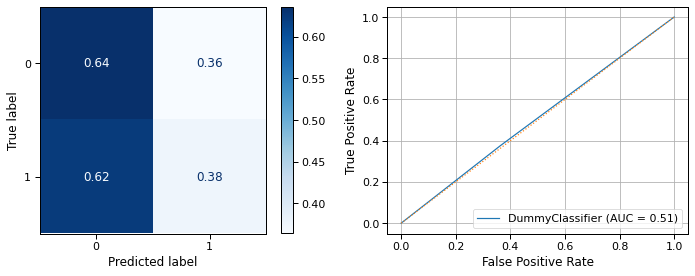


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     56374
           1       0.37      0.37      0.37     33168

    accuracy                           0.53     89542
   macro avg       0.50      0.50      0.50     89542
weighted avg       0.53      0.53      0.53     89542



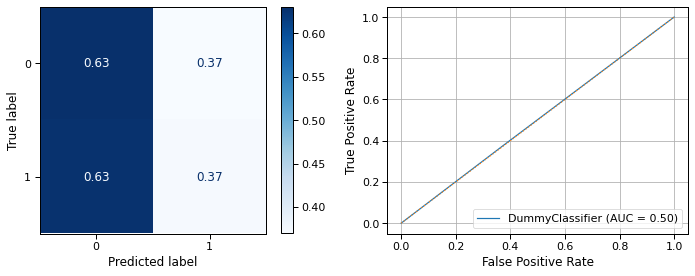

In [17]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)
base.fit(X_train_tf_df, y_train)

clf.evaluate_classification(base,X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test, 
                           metric = 'balanced accuracy')

# **Logistic Regression Model**

---

**Results:**

> Training balanced accuracy score: 0.82
> 
> Testing balanced accuracy score: 0.82
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.37
>
> Testing data log loss: 0.37

---

**Interpretation**

> 

---

In [18]:
## LogReg Model
logreg = LogisticRegression(max_iter = 600, C = .1,solver = 'lbfgs',
                            random_state = 42)

logreg.fit(X_train_tf_df, y_train)

LogisticRegression(C=0.1, max_iter=600, random_state=42)


|-------------------------------- Classification Metrics -----------------------------------|

Training balanced recall score: 0.79
Testing balanced recall score: 0.78
	- The training score is larger by 0.01 points.

Training data log loss: 0.38
Testing data log loss: 0.39



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.82      0.90      0.86     18792
           1       0.80      0.66      0.72     11056

    accuracy                           0.81     29848
   macro avg       0.81      0.78      0.79     29848
weighted avg       0.81      0.81      0.81     29848



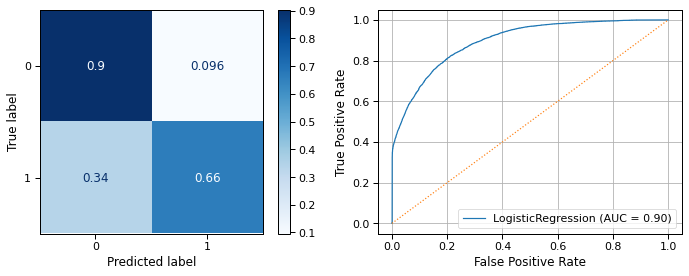


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.83      0.91      0.87     56374
           1       0.81      0.68      0.74     33168

    accuracy                           0.82     89542
   macro avg       0.82      0.79      0.80     89542
weighted avg       0.82      0.82      0.82     89542



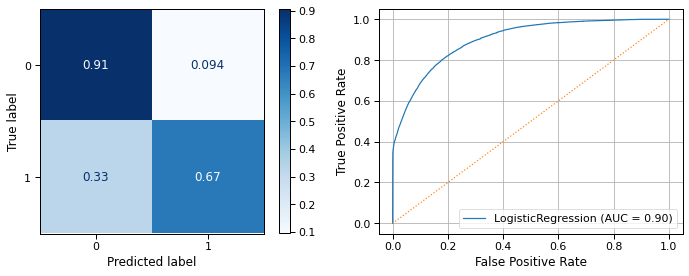

In [19]:
clf.evaluate_classification(logreg, X_train = X_train_tf_df,y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

## **Collecting Coefficients**

---

> I feel confident in my model's balanced accuracy score. Now I will collect the results for my features and generate a visualization of the results.

---

In [20]:
## Collecting coefficients for each feature as a Series
lr_coefs = pd.Series(logreg.coef_.flatten(), index=X_train_tf_df.columns)
lr_coefs.sort_values(ascending=False, inplace=True)
lr_coefs

deposit_type_Non Refund        2.61
previous_cancellations         1.80
country_PRT                    1.66
country_AGO                    1.16
agent_group_9                  0.92
                               ... 
agent_group_999               -0.86
deposit_type_Refundable       -0.94
agent_group_1                 -0.96
deposit_type_No Deposit       -1.68
required_car_parking_spaces   -1.70
Length: 238, dtype: float64

In [21]:
## Converting top/bottom 5 values into a Series
log_odds = pd.concat([lr_coefs.head(5), lr_coefs.tail(5)])
log_odds

deposit_type_Non Refund        2.61
previous_cancellations         1.80
country_PRT                    1.66
country_AGO                    1.16
agent_group_9                  0.92
agent_group_999               -0.86
deposit_type_Refundable       -0.94
agent_group_1                 -0.96
deposit_type_No Deposit       -1.68
required_car_parking_spaces   -1.70
dtype: float64

In [22]:
## Formatting index labels to become visualization labels
new_labels_list = [i.replace('_', ' ').title() for i in list(log_odds.index)]
new_labels_list

['Deposit Type Non Refund',
 'Previous Cancellations',
 'Country Prt',
 'Country Ago',
 'Agent Group 9',
 'Agent Group 999',
 'Deposit Type Refundable',
 'Agent Group 1',
 'Deposit Type No Deposit',
 'Required Car Parking Spaces']

In [23]:
## Creating a dictionary to replace the old lables with the new ones
new_labels_dict = { k:v for (k,v) in zip(log_odds.index, new_labels_list)}
new_labels_dict

{'deposit_type_Non Refund': 'Deposit Type Non Refund',
 'previous_cancellations': 'Previous Cancellations',
 'country_PRT': 'Country Prt',
 'country_AGO': 'Country Ago',
 'agent_group_9': 'Agent Group 9',
 'agent_group_999': 'Agent Group 999',
 'deposit_type_Refundable': 'Deposit Type Refundable',
 'agent_group_1': 'Agent Group 1',
 'deposit_type_No Deposit': 'Deposit Type No Deposit',
 'required_car_parking_spaces': 'Required Car Parking Spaces'}

In [24]:
## Renaming Series index
log_odds = log_odds.rename(new_labels_dict)
log_odds.sort_values(inplace=True)

log_odds

Required Car Parking Spaces   -1.70
Deposit Type No Deposit       -1.68
Agent Group 1                 -0.96
Deposit Type Refundable       -0.94
Agent Group 999               -0.86
Agent Group 9                  0.92
Country Ago                    1.16
Country Prt                    1.66
Previous Cancellations         1.80
Deposit Type Non Refund        2.61
dtype: float64

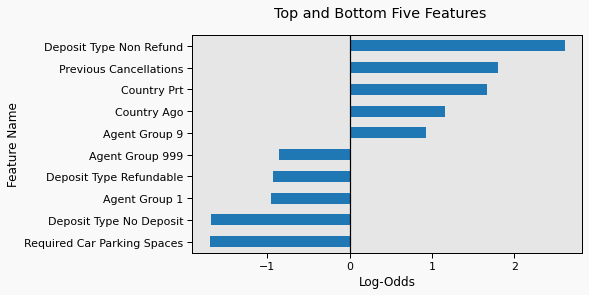

In [25]:
## Visualizing log-odds

fig, ax = plt.subplots(figsize=(7,4))

ax = log_odds.plot(kind='barh', ax=ax)
ax.axvline(linestyle = '-', c='k')
ax.set_xlabel('Log-Odds')
ax.set_ylabel('Feature Name')
fig.suptitle('Top and Bottom Five Features')
ax.set_facecolor('0.9')
fig.set_facecolor('0.975')
# plt.savefig('./img/log_odds.png',transparent=False, bbox_inches='tight',
#            dpi=100)
plt.show()
plt.close()

---

***May the (Log-)Odds be Ever in Your Favor***

> Based on the logistic regression model coefficients, I see that reservations are **most likely to cancel** if they:
* Require non-refundable deposits (possibly 3rd-party booking sites like )
* Are booked by agents 17 or 240
* Have previous cancellations
* Guests are from Portugal ([PRT is the three letter ISO 3166-1 code for Portugal](https://en.wikipedia.org/wiki/Portugal#:~:text=ISO%203166%20code,PT))
>
> Alternatively, reservations are **least likely to cancel** if they:
* Do NOT require a deposit
* Require parking spaces
* Reserve room type "A"
* Are assigned to room type "I"
* Are booked by agent 152

***Oddities in the Results***

> **Non-Refundable Deposit Requirement**
* May be associated with 3rd party travel groups like Priceline/Expedia/etc.
    * Often require pre-payment to the booking group/agent to confirm booking
>
> **Country of Origin: Portugal**
* Could these hotels be located in Portugal and have a larger percentage of domestic travelers?
>
> **Room Assignment, Required Car Parking Spaces**
* These features may be generated post-stay and may not be available prior to arrival
* Parking spot requirements may be specified prior to arrival, but not as likely in my personal experience.

---

# LogRegCV

---

>

---

In [35]:
lrcv = LogisticRegressionCV(class_weight = 'balanced', max_iter = 250, random_state = 42)

lrcv.fit(X_train_tf_df, y_train)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the doc

LogisticRegressionCV(class_weight='balanced', max_iter=500, random_state=42)

In [ ]:
clf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

# **Random Forest Model**

---

**Results:**

> Training balanced recall score: 0.99
> 
> Testing balanced recall score: 0.88
>
> * *The training score is larger by 0.11 points.*
>
> Training data log loss: 0.08
>
> Testing data log loss: 0.27

---

**Interpretation**

> 

---

In [ ]:
rfc = RandomForestClassifier(class_weight='balanced', random_state=42,
                             n_jobs=-1)

rfc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

In [ ]:
clf.plot_importances(rfc, X_train_tf_df)

# **ExtraTreesClassifier**

## 🛑 Test post-data changes; remove if not significant impact

---

**Results:**

> Training balanced recall score: 1.0
> 
> Testing balanced recall score: 0.87
> 
> * 
>
> Training data log loss: 0.01
>
> Testing data log loss: 0.33

---

**Interpretation**

> 

---

In [ ]:
etc = ExtraTreesClassifier(class_weight ='balanced',random_state=42,
                           n_jobs = -1)

etc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(etc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

# **Balanced Random Forest Classifier**

---

**MODEL: BalancedRandomForestClassifier**

**Scores**

> Training balanced accuracy score: 0.97
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.8 points.*
>
> Training data log loss: 0.17
>
> Testing data log loss: 0.30

---

**Best Parameters**

> 

**Interpretation**

> 

---

In [ ]:
brfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1)

brfc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(brfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

# TODO: Add GSCV

---

> Select best performing model or two and perform GS; not for all models.

---

# **Interpreting Results**

## 🛑 FIX: adjust for context of only B/RFC

---

**Odd Features**

> Now that I completed my modeling steps, I will review the results of each model and determine my final recommendations.
>
> My main models are a standard logistic regression and a Balanced Random Forest classifier ("BRFC"). **Each model provides a different way of identifying which features are most impactful: logistic regressions provide "log-odds" and a Balanced Random Forest Classifier produces "feature importances."** Both will require some processing for easy interpretation.

**Feature Importances and SHAP**

> As I mention above, tree-based models, including my BRFC-model, return "feature importances" instead of the coefficients associated with linear/logistic regressions. These values are useful to show the impact of a given feature on the decision-making steps of the tree model. 
>
>However, these feature importances suffer from one key weakness: *they do not indicate if a feature increases or decreases the likelihood of a reservation canceling (my target feature).*
>
> I will utilize a visualization package called **SHAP** to produce "Shapely values" for each feature. These values indicate each feature's marginal contribution to the model - answering the question, "*How well does the model perform with this feature than without?*" 

**Seeing is Believing**

>Using tools within the package, I will focus on two visualizations:
> * The `summary_plot`: visualizing each feature's Shapely value and the feature's values from low-high (relative to each feature).
>
>
> * The `force_plot`: an in-depth look at the forces impacting any given reservation record.
>
> More information about SHAP:
* [SHAP Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
* [SHAP Repository](https://github.com/slundberg/shap)

---

# **SHAP**

---

**Purpose**

> 

**Process**

> 

**Performance**

> 

---

# 🛑 Fix: Annotate Code and Update

In [ ]:
raise Exception('Hold for Testing SHAP Visualizations')

In [ ]:
 ## Initializing Javascript for SHAP models
shap.initjs()

In [ ]:
## Generating a sample of the overall data for review:

X_shap = shap.sample(X_test_tf_df, nsamples=500)

## Attempting TreeExplainer

In [ ]:
## Initializing an explainer with the RandomForestClassifier model
t_explainer = shap.TreeExplainer(rfc)

In [ ]:
## Calculating SHAP values for test data
shap_values = t_explainer.shap_values(X_shap,y_test)
len(shap_values)

## Attempting KernelExplainer

In [ ]:
k_explainer = shap.KernelExplainer(rfc.predict, X_shap)
k_explainer

In [ ]:
## Calculate shap values for test data
shap_values = k_explainer.shap_values(X_shap, nsamples=100)
len(shap_values)

In [ ]:
## Inspecting sizes of SHAP values vs. X_train_tf_df data - same # columns
shap_values[1].shape, X_test_tf_df.shape

In [ ]:
## Visualizing top 25 importances
# shap.summary_plot(shap_values, X_test_tf_df, plot_type='bar', max_display=25)

In [ ]:
## Better plot
shap.summary_plot(shap_values,X_shap,max_display=25)

## **Force Plot**

In [ ]:
target_lookup = {0:'Check-Out',1:'Canceled'}
target_lookup[1]

In [ ]:
row = np.random.choice(range(len(shap_values)))
print(f"- Row #: {row}")
print(f"Class = {target_lookup[y_test.iloc[row]]}")
X_test_tf_df.iloc[row].round(2)

In [ ]:
explainer.expected_value

In [ ]:
## Individual forceplot
shap.force_plot(explainer.expected_value, shap_values[1][row],shap_values.iloc[row])

In [ ]:
## Overall Forceplot
shap.force_plot(explainer.expected_value[1], shap_values[1],X_test_tf_df)       

## Dependence Plot

In [ ]:
shap.dependence_plot('Lead Time',shap_values[1],X_test_tf_df)

# MVP Notes

* CLF results - feature importances
* feature importances - visualize via SHAP


# Reviewing Results

---

> After testing several models, I found that MODELNAMEHERE produced the most accurate results.
>
> TOP 5 STRONGEST INDICATORS - Canceled Reservations:
> * 
> * 
> * 
>
> TOP 5 STRONGEST INDICATORS - Actualized Reservations:
> * 
> * 
> * 

---

# Recommendations

---

> Operationally, these results give us data-supported insights into our future guests and their needs. Once deployed, hotels would be able to use this model to forecast potential occupancy and staffing/supply needs. 
>
> Additionally, Operations teams would be able to determine how many and which guests would be the most likely to cancel their reservations. This information is very useful during periods of high-occupancy, particularly when trying to determine which guests to relocate in case of an oversold hotel.

---

# Future Work

---

> Time series modeling - forecasting based off of daily average probabilities (for a given # of arrivals, what is the forecast of %/# CXL?

> TSM - vector autoregressive forecasting using features to predict # cxl

> *Major stretch goal/future work:* determining likelihood of cancellations at given thresholds - e.g. 0-3, 4-7, 7-14, etc. days out
* What would be feature importances/coefficients at each threshold?
* Could I group the reservations based on their lead time despite different years?

---